Продвинутый вариант.



#Загрузка датасета.

In [1]:
import pandas as pd

In [6]:
data_path = '/content/drive/MyDrive/ML/TUSUR_ML/#5_ensemble/data/'

df = pd.read_csv(data_path + 'preprocessed_orders_short.csv', index_col=0)

In [7]:
df.head(5)

,store_id,order_id,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,5014.0,20562761.0,45.5040,2205.0,15.0,683.0,30.49,2.0,1.0
2,3856.0,20562753.0,30.3360,1368.0,10.0,683.0,240.78,2.0,1.0
4,10825.0,20562723.0,43.6080,459.0,20.0,683.0,85.99,1.0,1.0
5,8535.0,20562639.0,11.3128,1749.0,10.0,685.0,80.09,5.0,1.0
10,11449.0,20562617.0,4.4240,1040.0,20.0,695.0,85.99,1.0,1.0


#Подготовка данных



##Разделение данных на тестовую и обучающую выборки, выделение целевой переменной.

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(['prepared_on_time'], axis = 1).copy()
y = df['prepared_on_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 44, test_size = 0.3, stratify = y)

# Ансамбль моделей
Для сравнения выбраны модели BaggingClassifier и RandomForestClassifier.

## BaggingClassifier

In [8]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import optuna

# Функция для подбор гиперпараметров
def get_params(trial):
  n_estimators = trial.suggest_int('n_estimators', 2, 100)      # количество решающих деревьев
  max_depth = trial.suggest_int('max_depth', 2, 20)             # макс глубина
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10) # мин количество деревьев в листе

  base_estimator = DecisionTreeClassifier(
      max_depth = max_depth,
      min_samples_leaf = min_samples_leaf,
      class_weight = 'balanced'
  )

  ensemble = BaggingClassifier(
      estimator = base_estimator,
      n_estimators = n_estimators,
      random_state = 44
  )

  # Оцениванием ансамбль по точность (Accuracy)
  score = cross_val_score(ensemble, X_train, y_train, cv = 5, scoring = 'accuracy').mean()
  return score


study = optuna.create_study(direction = 'maximize')
study.optimize(get_params, n_trials = 50)
trial = study.best_trial

print('Accuracy: ', trial.value)
print('Best params:', trial.params)

[I 2024-12-17 17:12:56,290] A new study created in memory with name: no-name-9b1f34a0-93be-4f18-b380-d5772cf85859
[I 2024-12-17 17:13:02,566] Trial 0 finished with value: 0.7784715461164002 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7784715461164002.
[I 2024-12-17 17:13:05,416] Trial 1 finished with value: 0.5768480305575898 and parameters: {'n_estimators': 59, 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7784715461164002.
[I 2024-12-17 17:13:14,505] Trial 2 finished with value: 0.8007705452404543 and parameters: {'n_estimators': 88, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8007705452404543.
[I 2024-12-17 17:13:15,502] Trial 3 finished with value: 0.6116044170651503 and parameters: {'n_estimators': 19, 'max_depth': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8007705452404543.
[I 2024-12-17 17:13:25,009] Trial 4 finished with value: 0.767443817401169 and p

Accuracy:  0.8333744022745876
Best params: {'n_estimators': 99, 'max_depth': 18, 'min_samples_leaf': 1}


Значение Accuracy = 83%, говорит о довольно хорошей предсказательной способности модели.

##RandomForestClassifier

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

best_params = study.best_params

# Обучаем модели на лучших гиперпараметрах
best_bagging = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        max_depth = best_params['max_depth'],
        min_samples_leaf = best_params['min_samples_leaf'],
        class_weight = 'balanced'
    ),
    n_estimators = best_params['n_estimators'],
    random_state = 44
)

best_bagging.fit(X_train, y_train)

random_forest = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_leaf = best_params['min_samples_leaf'],
    class_weight = 'balanced',
    random_state = 44
)

random_forest.fit(X_train, y_train)

# Предсказываем значения, для получения метрик и сравнения
best_bagging_pred = best_bagging.predict(X_test)
random_forest_pred = random_forest.predict(X_test)

print('BaggingClassifier:')
print(classification_report(y_test, best_bagging_pred))
print('Accuracy: ', accuracy_score(y_test, best_bagging_pred))
print('Precision: ', precision_score(y_test, best_bagging_pred))
print('Recall: ', recall_score(y_test, best_bagging_pred))
print('F1-Score: ', f1_score(y_test, best_bagging_pred))

print('\n\nRandomForestClassifier:')
print(classification_report(y_test, random_forest_pred))
print('Accuracy: ', accuracy_score(y_test, random_forest_pred))
print('Precision: ', precision_score(y_test, random_forest_pred))
print('Recall: ', recall_score(y_test, random_forest_pred))
print('F1-Score: ', f1_score(y_test, random_forest_pred))

BaggingClassifier:
              precision    recall  f1-score   support

         0.0       0.29      0.01      0.03       294
         1.0       0.84      0.99      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.56      0.50      0.47      1788
weighted avg       0.75      0.83      0.76      1788

Accuracy:  0.8322147651006712
Precision:  0.8365276211950394
Recall:  0.9933065595716198
F1-Score:  0.9082007343941249


RandomForestClassifier:
              precision    recall  f1-score   support

         0.0       0.30      0.01      0.02       294
         1.0       0.84      1.00      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.57      0.50      0.46      1788
weighted avg       0.75      0.83      0.76      1788

Accuracy:  0.8333333333333334
Precision:  0.8363329583802025
Recall:  0.9953145917001339
F1-Score:  0.9089242053789731


##Сравнение моделей

Метрики обех моделех схожи, однако RandomForestClassifier показывает более высокую точность — 83.55% и чуть лучшее значение F1 меры — 91.03%, что указывает на более сбалансированное соотношение Precision и Recall.

Для класса 0 обе модели показывают крайне низкие значения Precision и Recall, из-за сильного дисбаланса в данных.

#Визуализация и выводы

##Построение графика зависимости точность ансамблей на кросс-валидации от числа базовых моделей.  

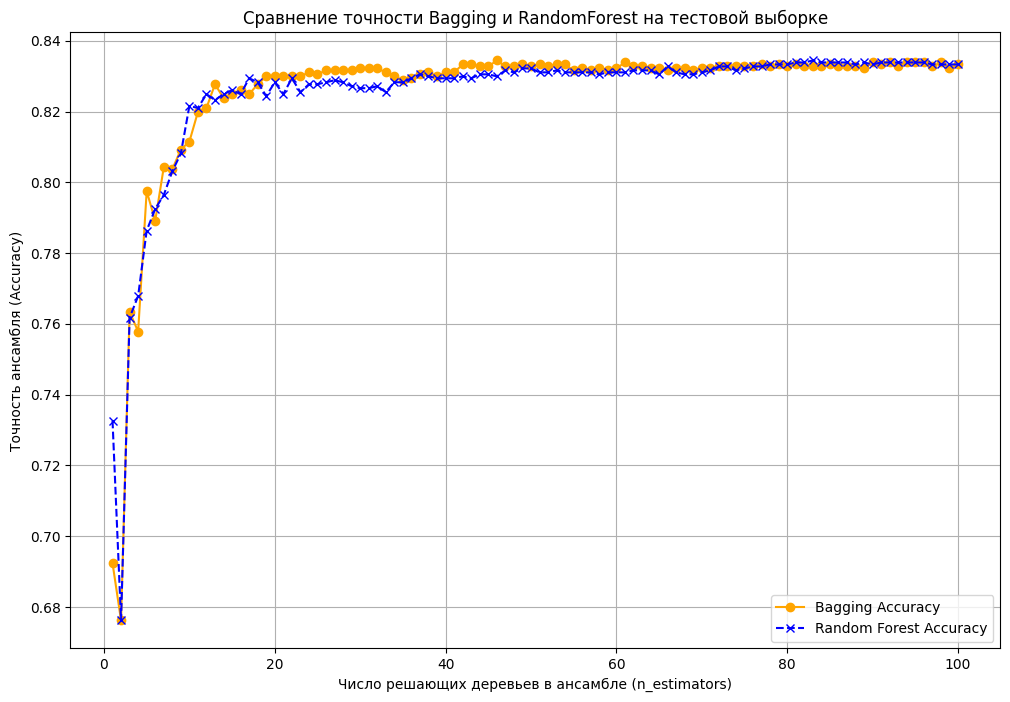

In [14]:
import matplotlib.pyplot as plt

# Лучшие параметры
max_depth = best_params["max_depth"]
min_samples_leaf = best_params["min_samples_leaf"]

n_estimators_range = list(range(1, 101))  # Количество деревьев от 1 до 100
bagging_scores = []
rf_scores = []


for n_estimators in n_estimators_range:
    # Bagging
    bagging_model = BaggingClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced"
        ),
        n_estimators=n_estimators,
        random_state=44
    )
    bagging_model.fit(X_train, y_train)
    bagging_score = bagging_model.score(X_test, y_test)
    bagging_scores.append(bagging_score)

    # RandomForest
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=44
    )
    rf_model.fit(X_train, y_train)
    rf_score = rf_model.score(X_test, y_test)
    rf_scores.append(rf_score)

# Построение графика
plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, bagging_scores, marker='o', linestyle='-', color='orange', label='Bagging Accuracy')
plt.plot(n_estimators_range, rf_scores, marker='x', linestyle='--', color='blue', label='Random Forest Accuracy')
plt.xlabel("Число решающих деревьев в ансамбле (n_estimators)")
plt.ylabel("Точность ансамбля (Accuracy)")
plt.title("Сравнение точности Bagging и RandomForest на тестовой выборке")
plt.legend()
plt.grid(True)
plt.show()

Графики для Bagging и RandomForest практически индентичны: существенное улучшение качества ансамблей наблюдается лишь до 20 моделей. Далее прирост качества не так существенен и его значение варьируется в районе 83%. После достижения максимального значения точности графики стабилены, что говорит об отсутсвии у выбранных ансамблевых моделей склонности к переобучению.   